In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import gym
import dacmdp
import dacmdp.envs as ce
# import wandb as wandb_logger

/home/aayam/miniconda3/envs/dacmdp/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from munch import munchify 

config = munchify({
"envArgs":{'env_name': 'CartPole-cont-v1', 'seed': 0},
"logArgs":{'wandb_id': "cartpole_online_test_1", "wandb_entity":"dacmdp",
           "wandb_project":"dacmdp_online_test_v0", "no_wandb_logging":True},
"dataArgs": {'buffer_name': 'random', 'buffer_size': 25000, 
             'load_buffer': False, 'buffer_device': 'gpu', "data_dir":""},
"reprModelArgs": {'repr_model_name': 'OracleDynamicsRepr', 's_multiplyer': 1, 'a_multiplyer': 10, 'repr_dim': 4},
"actionModelArgs": {'action_model_name': 'NNActionModelCuda', 'nn_engine': "torch_pykeops"},
"mdpBuildArgs": {'n_tran_types': 10, 'n_tran_targets': 5, 'penalty_beta': 1.0, 'penalty_type': 'linear', 'rebuild_mdpfcache': False,
                 'save_mdp2cache': False, 'save_folder': '/nfs/hpc/share/shrestaa/storage/dac_storage_22_Q4/mdp_dumps/random_hash'},
"mdpSolveArgs": {'device': 'cuda', 'max_n_backups': 5000, "gamma": 0.99, 'epsilon': 0.0001, 'penalty_beta': 1, "operator": "simple_backup"},
"evalArgs": {'eval_episode_count': 50, "skip_eval":True, "skip_dist_log":True},
})

flat_args = lambda config : {f"{K}::{k}":v for K in config for k,v in config[K].items() if K != "flat_args"}

In [5]:
config.logArgs

Munch({'wandb_id': 'cartpole_online_test_1', 'wandb_entity': 'dacmdp', 'wandb_project': 'dacmdp_online_test_v0', 'no_wandb_logging': True})

In [6]:
if not config.logArgs.no_wandb_logging:
    wandb_logger.init( id = config.logArgs.wandb_id ,
        entity=config.logArgs.wandb_entity,
        project=config.logArgs.wandb_project,
        config = flat_args(config),
        resume = "allow")

In [7]:
env = gym.make(config.envArgs.env_name)

In [8]:
from dacmdp.core.models_action import NNActionModel, GlobalClusterActionModel, EnsembleActionModel
from dacmdp.core.models_sa_repr import OracleDynamicsRepr, DeltaPredictonRepr

######### Get Action and Repr Models ####################################
seed_buffer = dacmdp.utils_buffer.generate_or_load_buffer(config, env)
cluster_action_count = 10
cluster_action_model = GlobalClusterActionModel(action_space=env.action_space,
                                   n_actions= cluster_action_count,
                                   data_buffer=seed_buffer)

sa_repr_model = OracleDynamicsRepr(env_name = config.envArgs.env_name)

######################################################################################################

Average Reward of collected trajectories:17.205
Collected buffer!
K-means for the Euclidean metric with 25,016 points in dimension 1, K = 10:
Timing for 50 iterations: 0.03100s = 50 x 0.00062s



In [9]:
# import d4rl

In [10]:
cluster_action_model.cand_actions_for_states(torch.FloatTensor(seed_buffer.state[0:1]).cuda())

tensor([[[-0.4978],
         [ 0.4955],
         [ 0.9016],
         [-0.0936],
         [ 0.2956],
         [-0.6976],
         [-0.2966],
         [ 0.1011],
         [-0.9001],
         [ 0.6990]]])

In [11]:
cluster_action_model.cand_actions_for_states(torch.FloatTensor(seed_buffer.state[0:100]).cuda()).shape,\
sa_repr_model.encode_state_action_pairs(torch.FloatTensor(seed_buffer.state[0:100]),
                                       torch.FloatTensor(seed_buffer.action[0:100])).shape

/home/aayam/Documents/workspaces/dacmdp/dacmdp/envs/cont_cartpole.py:108: UserWarning: WARN: 
You are calling 'step()' even though this environment has already returned
done = True. You should always call 'reset()' once you receive 'done = True'
Any further steps are undnp.float32(low), np.float32(high)efined behavior.
                
  """)


(torch.Size([100, 10, 1]), torch.Size([100, 4]))

In [12]:
from dacmdp.data.utils_buffer import StandardElasticBuffer
global_buffer = StandardElasticBuffer(state_shape = env.observation_space.shape,
               action_shape = [len(env.action_space.sample())], # for discrete settings. 
                batch_size=32, buffer_size=100000, device="cpu")
# policy liftup functions
def dummy_lifted_policy(Agent, s, epsilon):
    if torch.rand(1).item() < epsilon:
        return env.action_space.sample()
    else:
        nn_s_idx =  THelper.calc_knn_indices(torch.FloatTensor(s).to(Agent.device), Agent.dacmdp_core.S, 1)[0]
        policy_idx = Agent.dacmdp_core.Pi[nn_s_idx] 
        return Agent.A_names[nn_s_idx,policy_idx].cpu().numpy()

In [13]:
config.evalArgs.skip_eval = False

In [16]:
import time
import matplotlib.pyplot as plt 
import numpy as np 
from dacmdp.core.utils_misc import plot_distributions_as_rgb_array
from dacmdp.eval.utils_eval import evaluate_on_env
from dacmdp.data.utils_buffer import StandardBuffer
from dacmdp.core.dac_core import DACTransitionBatch
from dacmdp.core.dac_build import DACBuildWithActionNames
from dacmdp.core.utils_knn import THelper

total_training_points = 200000
point_batch_size = 10000
curr_data_points = 0
avg_rewards = 0
rewards_log = []
dac_plot_log = []
images = 0

# Instantiate Elastic Agent
config.mdpBuildArgs.n_tran_types = cluster_action_count + 5
elasticAgent = DACBuildWithActionNames( config = config, 
                                    action_space = env.action_space, 
                                    action_model = cluster_action_model, # Update this later.
                                    repr_model = sa_repr_model, 
                                    effective_batch_size= 1000, 
                                    batch_calc_knn_ret_flat_engine = THelper.batch_calc_knn_ret_flat_pykeops
                                    )

for epoch_i in range(100):
    ######### TT 1: Data collect   ###########################################################################
    random_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 1)
    explore_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 0.1)
    optimal_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 0)
        
    data_buffer = StandardBuffer(state_shape = env.observation_space.shape,
                           action_shape = [len(env.action_space.sample())], # for discrete settings. 
                            batch_size=32, buffer_size=point_batch_size, device="cpu")
    data_buffer, info_explore = StandardBuffer.populate_buffer(data_buffer, env, 
                                                   policy = random_policy if epoch_i ==0 else explore_policy,
                                                   episode_count=10, 
                                                   frame_count=int(point_batch_size/2))
    data_buffer, info_optimal = StandardBuffer.populate_buffer(data_buffer, env, 
                                                   policy = random_policy if epoch_i ==0 else optimal_policy,
                                                   episode_count=10, 
                                                   frame_count=int(point_batch_size/2))
    global_buffer.append_buffer(data_buffer)
    ######################################################################################################
    
    
    ######### TT 2: Update Action Model  ###########################################################################
    # Action Model
    nn_action_model = NNActionModel(action_space = env.action_space,
                                   n_actions = 5,
                                   data_buffer = global_buffer,
                                   nn_engine= config.actionModelArgs.nn_engine,
                                   projection_fxn=lambda s: s, 
                                   )
    action_model = EnsembleActionModel(env.action_space,[nn_action_model, cluster_action_model])
    # action_model = cluster_action_model
    config.mdpBuildArgs.n_tran_types = action_model.n_actions
    elasticAgent.action_model = action_model
    
    sa_repr_model = DeltaPredictonRepr(s_multiplyer=2, 
                                   a_multiplyer=1,
                                   buffer=global_buffer,
                                   nn_engine="torch_pykeops")
    elasticAgent.repr_model = sa_repr_model
    ######################################################################################################
    

    ######### TT 3: DACMDP Elastic Build   ###########################################################################
    transitions = DACTransitionBatch(torch.FloatTensor(data_buffer.state).clone().detach(),
                                    torch.FloatTensor(data_buffer.action).clone().detach(),
                                    torch.FloatTensor(data_buffer.next_state).clone().detach(),
                                    torch.FloatTensor(data_buffer.reward.reshape(-1)).clone().detach(), 
                                    torch.LongTensor((1- data_buffer.not_done).reshape(-1)).clone().detach())

    st = time.time()
    elasticAgent.consume_transitions(transitions, verbose = True, batch_size = 1000)
    elasticAgent.dacmdp_core.solve(max_n_backups = config.mdpSolveArgs.max_n_backups, 
                                   penalty_beta = config.mdpSolveArgs.penalty_beta, 
                                   epsilon = config.mdpSolveArgs.epsilon, 
                                   gamma = config.mdpSolveArgs.gamma, 
                                   operator="simple_backup", 
                                   bellman_backup_batch_size=500)

    print(f"Epoch {epoch_i}: Graph built and solved in {time.time()-st:.2f} Seconds")
    ######################################################################################################

    
    ######### TT 4: Eval  ###########################################################################
    if not config.evalArgs.skip_eval:
        st = time.time()
        eval_policy = lambda s:dummy_lifted_policy(elasticAgent,s, epsilon = 0)
        config.evalArgs.eval_episode_count = 100
        avg_rewards, info = evaluate_on_env(env, eval_policy, eps_count=config.evalArgs.eval_episode_count)
        eval_time =  time.time()-st
        print(f"Epoch {epoch_i}: Evaluation compltete", avg_rewards, "Time: ",eval_time, "Seconds")
        rewards_log.append(avg_rewards)
        
    if not config.evalArgs.skip_dist_log:
        image_array= plot_distributions_as_rgb_array(elasticAgent.dacmdp_core.mdp_distributions)
        dac_plot_log.append(image_array)
        images = wandb_logger.Image(image_array, caption="MDP Distributions")
    
    if not config.logArgs.no_wandb_logging:   
        wandb_logger.log({"epoch_i":epoch_i, "buffer_size":len(global_buffer), "Average Reward":avg_rewards,
                         "explore_data_collection_traj_reward":np.mean(info_explore["all_rewards"]), 
                         "optimal_data_collection_traj_reward":np.mean(info_optimal["all_rewards"]), 
                         "mdp_distribution":images
                         })

    ######################################################################################################

dacmdp_core_defined
Using pre-initialized Action Model GlobalClusterActionModel
Using pre-initialized Action Model <dacmdp.core.models_sa_repr.DeltaPredictonRepr object at 0x7f55d6d3f490>
Average Reward of collected trajectories:18.6
Average Reward of collected trajectories:14.7


Caculating State Representations: : 41it [00:00, 31363.57it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(10000, 15, 5)
nn after consumption,  10000


Calculate Candidate Actions: : 10it [00:00, 408.52it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 360.47it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 276.66it/s]
Update Transition model of core dacmdp: : 10it [00:00, 198.45it/s]

0 tensor(1.)


500 tensor(0.0066)
1000 tensor(6.8665e-05)
Solved MDP in 1000 Backups
Epoch 0: Graph built and solved in 0.28 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.97it/s]


Epoch 0: Evaluation compltete 260.71 Time:  6.692664623260498 Seconds
Average Reward of collected trajectories:204.7
Average Reward of collected trajectories:235.1


Caculating State Representations: : 58it [00:00, 56931.81it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(20000, 15, 5)
nn after consumption,  20000


Calculate Candidate Actions: : 10it [00:00, 356.65it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 332.19it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 274.30it/s]
Update Transition model of core dacmdp: : 10it [00:00, 171.35it/s]

0 tensor(99.7774)


500 tensor(0.0003)
1000 tensor(1.5259e-05)
Solved MDP in 1000 Backups
Epoch 1: Graph built and solved in 0.31 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.90it/s]


Epoch 1: Evaluation compltete 392.17 Time:  11.249489307403564 Seconds
Average Reward of collected trajectories:274.6
Average Reward of collected trajectories:419.4


Caculating State Representations: : 85it [00:00, 58550.80it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(30000, 15, 5)
nn after consumption,  30000


Calculate Candidate Actions: : 10it [00:00, 317.26it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 311.36it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 250.45it/s]
Update Transition model of core dacmdp: : 10it [00:00, 162.45it/s]

0 tensor(99.9915)


500 tensor(0.0003)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 2: Graph built and solved in 0.37 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.76it/s]


Epoch 2: Evaluation compltete 399.36 Time:  11.427972316741943 Seconds
Average Reward of collected trajectories:207.4
Average Reward of collected trajectories:448.1


Caculating State Representations: : 111it [00:00, 47386.03it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(40000, 15, 5)
nn after consumption,  40000


Calculate Candidate Actions: : 10it [00:00, 258.07it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 289.98it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 238.27it/s]
Update Transition model of core dacmdp: : 10it [00:00, 142.31it/s]


0 tensor(99.9945)
500 tensor(0.0001)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 3: Graph built and solved in 0.43 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.88it/s]


Epoch 3: Evaluation compltete 430.82 Time:  12.697758913040161 Seconds
Average Reward of collected trajectories:260.6
Average Reward of collected trajectories:398.8


Caculating State Representations: : 137it [00:00, 68163.66it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(50000, 15, 5)
nn after consumption,  50000


Calculate Candidate Actions: : 10it [00:00, 214.89it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 245.47it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 195.33it/s]
Update Transition model of core dacmdp: : 10it [00:00, 116.81it/s]


0 tensor(99.9967)
500 tensor(0.0007)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 4: Graph built and solved in 0.52 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.79it/s]


Epoch 4: Evaluation compltete 428.8 Time:  12.840603828430176 Seconds
Average Reward of collected trajectories:225.5
Average Reward of collected trajectories:447.5


Caculating State Representations: : 163it [00:00, 83486.57it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(60000, 15, 5)
nn after consumption,  60000


Calculate Candidate Actions: : 10it [00:00, 195.13it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 222.55it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 183.44it/s]
Update Transition model of core dacmdp: : 10it [00:00, 108.97it/s]


0 tensor(99.9960)
500 tensor(0.0004)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 5: Graph built and solved in 0.59 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.53it/s]


Epoch 5: Evaluation compltete 454.31 Time:  13.294954776763916 Seconds
Average Reward of collected trajectories:264.5
Average Reward of collected trajectories:447.7


Caculating State Representations: : 191it [00:00, 100151.53it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(70000, 15, 5)
nn after consumption,  70000


Calculate Candidate Actions: : 10it [00:00, 175.76it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 200.99it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 170.55it/s]
Update Transition model of core dacmdp: : 10it [00:00, 112.27it/s]


0 tensor(99.9971)
500 tensor(0.0001)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 6: Graph built and solved in 0.64 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.89it/s]


Epoch 6: Evaluation compltete 431.78 Time:  12.69064211845398 Seconds
Average Reward of collected trajectories:181.9
Average Reward of collected trajectories:477.5


Caculating State Representations: : 216it [00:00, 87255.10it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(80000, 15, 5)
nn after consumption,  80000


Calculate Candidate Actions: : 10it [00:00, 158.30it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 192.85it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 153.63it/s]
Update Transition model of core dacmdp: : 10it [00:00, 90.99it/s]


0 tensor(99.9970)
500 tensor(8.3923e-05)
Solved MDP in 500 Backups
Epoch 7: Graph built and solved in 0.52 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.76it/s]


Epoch 7: Evaluation compltete 436.94 Time:  12.903290271759033 Seconds
Average Reward of collected trajectories:222.2
Average Reward of collected trajectories:425.5


Caculating State Representations: : 242it [00:00, 118841.07it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(90000, 15, 5)
nn after consumption,  90000


Calculate Candidate Actions: : 10it [00:00, 147.64it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 180.62it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 145.96it/s]
Update Transition model of core dacmdp: : 10it [00:00, 105.22it/s]


0 tensor(99.9977)
500 tensor(0.0025)
1000 tensor(1.5259e-05)
Solved MDP in 1000 Backups
Epoch 8: Graph built and solved in 0.77 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.96it/s]


Epoch 8: Evaluation compltete 430.16 Time:  12.567831039428711 Seconds
Average Reward of collected trajectories:209.8
Average Reward of collected trajectories:468.4


Caculating State Representations: : 268it [00:00, 174274.96it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(100000, 15, 5)
nn after consumption,  100000


Calculate Candidate Actions: : 10it [00:00, 141.61it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 176.92it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 156.65it/s]
Update Transition model of core dacmdp: : 10it [00:00, 104.22it/s]


0 tensor(99.9979)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 9: Graph built and solved in 0.57 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.45it/s]


Epoch 9: Evaluation compltete 461.05 Time:  13.427865982055664 Seconds
Average Reward of collected trajectories:217.7
Average Reward of collected trajectories:474.6


Caculating State Representations: : 295it [00:00, 145327.66it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(110000, 15, 5)
nn after consumption,  110000


Calculate Candidate Actions: : 10it [00:00, 133.08it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 157.93it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 131.56it/s]
Update Transition model of core dacmdp: : 10it [00:00, 96.66it/s]


0 tensor(99.9974)
500 tensor(0.0060)
1000 tensor(3.8147e-05)
Solved MDP in 1000 Backups
Epoch 10: Graph built and solved in 0.90 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.84it/s]


Epoch 10: Evaluation compltete 429.0 Time:  12.766106367111206 Seconds
Average Reward of collected trajectories:259.6
Average Reward of collected trajectories:427.1


Caculating State Representations: : 322it [00:00, 140830.65it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(120000, 15, 5)
nn after consumption,  120000


Calculate Candidate Actions: : 10it [00:00, 119.45it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 155.95it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 160.29it/s]
Update Transition model of core dacmdp: : 10it [00:00, 85.77it/s]


0 tensor(99.9982)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 11: Graph built and solved in 0.66 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.53it/s]


Epoch 11: Evaluation compltete 446.23 Time:  13.29692029953003 Seconds
Average Reward of collected trajectories:267.6
Average Reward of collected trajectories:433.2


Caculating State Representations: : 349it [00:00, 142518.95it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(130000, 15, 5)
nn after consumption,  130000


Calculate Candidate Actions: : 10it [00:00, 114.83it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 142.06it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 115.94it/s]
Update Transition model of core dacmdp: : 10it [00:00, 80.36it/s]


0 tensor(99.9978)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 12: Graph built and solved in 0.73 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.77it/s]


Epoch 12: Evaluation compltete 442.79 Time:  12.875975370407104 Seconds
Average Reward of collected trajectories:188.4
Average Reward of collected trajectories:477.5


Caculating State Representations: : 375it [00:00, 118331.63it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(140000, 15, 5)
nn after consumption,  140000


Calculate Candidate Actions: : 10it [00:00, 108.56it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 142.30it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 118.84it/s]
Update Transition model of core dacmdp: : 10it [00:00, 76.36it/s]


0 tensor(99.9972)
500 tensor(0.0002)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 13: Graph built and solved in 1.11 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.95it/s]


Epoch 13: Evaluation compltete 427.74 Time:  12.585324048995972 Seconds
Average Reward of collected trajectories:238.9
Average Reward of collected trajectories:461.4


Caculating State Representations: : 403it [00:00, 115111.99it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(150000, 15, 5)
nn after consumption,  150000


Calculate Candidate Actions: : 10it [00:00, 102.19it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 135.66it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 105.94it/s]
Update Transition model of core dacmdp: : 10it [00:00, 71.91it/s]


0 tensor(99.9977)
500 tensor(0.0003)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 14: Graph built and solved in 1.18 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.64it/s]


Epoch 14: Evaluation compltete 448.22 Time:  13.103813886642456 Seconds
Average Reward of collected trajectories:147.6
Average Reward of collected trajectories:448.6


Caculating State Representations: : 426it [00:00, 138081.41it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(160000, 15, 5)
nn after consumption,  160000


Calculate Candidate Actions: : 10it [00:00, 97.63it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 127.66it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 110.73it/s]
Update Transition model of core dacmdp: : 10it [00:00, 73.91it/s]


0 tensor(99.9984)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 15: Graph built and solved in 0.83 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 15: Evaluation compltete 462.73 Time:  13.656243324279785 Seconds
Average Reward of collected trajectories:223.6
Average Reward of collected trajectories:491.7


Caculating State Representations: : 454it [00:00, 147923.10it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(170000, 15, 5)
nn after consumption,  170000


Calculate Candidate Actions: : 10it [00:00, 91.86it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 119.61it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 107.96it/s]
Update Transition model of core dacmdp: : 10it [00:00, 67.01it/s]


0 tensor(99.9981)
500 tensor(7.6294e-05)
Solved MDP in 500 Backups
Epoch 16: Graph built and solved in 0.89 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.35it/s]


Epoch 16: Evaluation compltete 471.0 Time:  13.614338397979736 Seconds
Average Reward of collected trajectories:231.4
Average Reward of collected trajectories:449.2


Caculating State Representations: : 481it [00:00, 181328.44it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(180000, 15, 5)
nn after consumption,  180000


Calculate Candidate Actions: : 10it [00:00, 87.01it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 125.43it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 125.00it/s]
Update Transition model of core dacmdp: : 10it [00:00, 66.42it/s]


0 tensor(99.9984)
500 tensor(3.0518e-05)
Solved MDP in 500 Backups
Epoch 17: Graph built and solved in 0.90 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.56it/s]


Epoch 17: Evaluation compltete 456.4 Time:  13.241358280181885 Seconds
Average Reward of collected trajectories:251.2
Average Reward of collected trajectories:464.1


Caculating State Representations: : 509it [00:00, 187354.17it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(190000, 15, 5)
nn after consumption,  190000


Calculate Candidate Actions: : 10it [00:00, 82.94it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 111.32it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 97.94it/s]
Update Transition model of core dacmdp: : 10it [00:00, 62.35it/s]


0 tensor(99.9980)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 18: Graph built and solved in 0.98 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.45it/s]


Epoch 18: Evaluation compltete 457.79 Time:  13.42880892753601 Seconds
Average Reward of collected trajectories:184.0
Average Reward of collected trajectories:500.0


Caculating State Representations: : 535it [00:00, 165997.38it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(200000, 15, 5)
nn after consumption,  200000


Calculate Candidate Actions: : 10it [00:00, 78.81it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 131.56it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 112.31it/s]
Update Transition model of core dacmdp: : 10it [00:00, 61.42it/s]


0 tensor(99.9972)
500 tensor(6.8665e-05)
Solved MDP in 500 Backups
Epoch 19: Graph built and solved in 0.98 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.81it/s]


Epoch 19: Evaluation compltete 445.66 Time:  12.814159870147705 Seconds
Average Reward of collected trajectories:263.9
Average Reward of collected trajectories:478.2


Caculating State Representations: : 564it [00:00, 113430.23it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(210000, 15, 5)
nn after consumption,  210000


Calculate Candidate Actions: : 10it [00:00, 74.66it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 121.02it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 106.00it/s]
Update Transition model of core dacmdp: : 10it [00:00, 59.12it/s]


0 tensor(99.9979)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 20: Graph built and solved in 1.03 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.55it/s]


Epoch 20: Evaluation compltete 457.43 Time:  13.25455355644226 Seconds
Average Reward of collected trajectories:298.7
Average Reward of collected trajectories:437.7


Caculating State Representations: : 593it [00:00, 142379.20it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(220000, 15, 5)
nn after consumption,  220000


Calculate Candidate Actions: : 10it [00:00, 73.75it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 128.26it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 105.36it/s]
Update Transition model of core dacmdp: : 10it [00:00, 58.48it/s]


0 tensor(99.9980)
500 tensor(6.8665e-05)
Solved MDP in 500 Backups
Epoch 21: Graph built and solved in 1.05 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.78it/s]


Epoch 21: Evaluation compltete 445.77 Time:  12.865071535110474 Seconds
Average Reward of collected trajectories:170.5
Average Reward of collected trajectories:448.3


Caculating State Representations: : 617it [00:00, 6395.65it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(230000, 15, 5)
nn after consumption,  230000


Calculate Candidate Actions: : 10it [00:00, 68.91it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 111.10it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 97.06it/s]
Update Transition model of core dacmdp: : 10it [00:00, 56.11it/s]


0 tensor(99.9973)
500 tensor(1.5259e-05)
Solved MDP in 500 Backups
Epoch 22: Graph built and solved in 1.11 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.89it/s]


Epoch 22: Evaluation compltete 442.48 Time:  12.680509328842163 Seconds
Average Reward of collected trajectories:190.0
Average Reward of collected trajectories:489.0


Caculating State Representations: : 644it [00:00, 218821.43it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(240000, 15, 5)
nn after consumption,  240000


Calculate Candidate Actions: : 10it [00:00, 61.11it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 91.37it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 95.06it/s]
Update Transition model of core dacmdp: : 10it [00:00, 52.37it/s]


0 tensor(99.9971)
500 tensor(2.2888e-05)
Solved MDP in 500 Backups
Epoch 23: Graph built and solved in 1.20 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.54it/s]


Epoch 23: Evaluation compltete 462.59 Time:  13.266698360443115 Seconds
Average Reward of collected trajectories:132.6
Average Reward of collected trajectories:446.6


Caculating State Representations: : 666it [00:00, 150175.07it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(250000, 15, 5)
nn after consumption,  250000


Calculate Candidate Actions: : 10it [00:00, 63.71it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 87.06it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 93.16it/s]
Update Transition model of core dacmdp: : 10it [00:00, 52.42it/s]


0 tensor(99.9984)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 24: Graph built and solved in 1.22 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.80it/s]


Epoch 24: Evaluation compltete 452.46 Time:  12.82999587059021 Seconds
Average Reward of collected trajectories:195.8
Average Reward of collected trajectories:456.5


Caculating State Representations: : 692it [00:00, 143942.59it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(260000, 15, 5)
nn after consumption,  260000


Calculate Candidate Actions: : 10it [00:00, 63.19it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 113.51it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 90.78it/s]
Update Transition model of core dacmdp: : 10it [00:00, 50.67it/s]


0 tensor(99.9984)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 25: Graph built and solved in 1.23 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


Epoch 25: Evaluation compltete 467.16 Time:  13.505635738372803 Seconds
Average Reward of collected trajectories:187.0
Average Reward of collected trajectories:430.2


Caculating State Representations: : 716it [00:00, 173090.59it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(270000, 15, 5)
nn after consumption,  270000


Calculate Candidate Actions: : 10it [00:00, 60.09it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 107.89it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 91.71it/s]
Update Transition model of core dacmdp: : 10it [00:00, 48.56it/s]


0 tensor(99.9972)
500 tensor(0.0014)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 26: Graph built and solved in 1.94 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.61it/s]


Epoch 26: Evaluation compltete 458.56 Time:  13.150527238845825 Seconds
Average Reward of collected trajectories:233.6
Average Reward of collected trajectories:497.3


Caculating State Representations: : 744it [00:00, 227562.33it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(280000, 15, 5)
nn after consumption,  280000


Calculate Candidate Actions: : 10it [00:00, 63.13it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 106.06it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 86.01it/s]
Update Transition model of core dacmdp: : 10it [00:00, 47.07it/s]


0 tensor(99.9972)
500 tensor(4.5776e-05)
Solved MDP in 500 Backups
Epoch 27: Graph built and solved in 1.31 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 27: Evaluation compltete 457.95 Time:  13.724427938461304 Seconds
Average Reward of collected trajectories:241.7
Average Reward of collected trajectories:466.1


Caculating State Representations: : 772it [00:00, 237896.02it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(290000, 15, 5)
nn after consumption,  290000


Calculate Candidate Actions: : 10it [00:00, 60.13it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 102.11it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 83.16it/s]
Update Transition model of core dacmdp: : 10it [00:00, 45.34it/s]


0 tensor(99.9985)
500 tensor(6.8665e-05)
Solved MDP in 500 Backups
Epoch 28: Graph built and solved in 1.35 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.36it/s]


Epoch 28: Evaluation compltete 455.97 Time:  13.602405786514282 Seconds
Average Reward of collected trajectories:244.0
Average Reward of collected trajectories:444.3


Caculating State Representations: : 799it [00:00, 146483.47it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(300000, 15, 5)
nn after consumption,  300000


Calculate Candidate Actions: : 10it [00:00, 54.70it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 90.69it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 81.80it/s]
Update Transition model of core dacmdp: : 10it [00:00, 44.87it/s]


0 tensor(99.9989)
500 tensor(0.0002)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 29: Graph built and solved in 2.14 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 29: Evaluation compltete 456.37 Time:  13.730581998825073 Seconds
Average Reward of collected trajectories:270.4
Average Reward of collected trajectories:405.7


Caculating State Representations: : 825it [00:00, 231226.25it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(310000, 15, 5)
nn after consumption,  310000


Calculate Candidate Actions: : 10it [00:00, 54.47it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 98.30it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 77.89it/s]
Update Transition model of core dacmdp: : 10it [00:00, 42.61it/s]


0 tensor(99.9986)
500 tensor(7.6294e-05)
Solved MDP in 500 Backups
Epoch 30: Graph built and solved in 1.45 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 30: Evaluation compltete 468.22 Time:  14.073994636535645 Seconds
Average Reward of collected trajectories:216.0
Average Reward of collected trajectories:498.0


Caculating State Representations: : 853it [00:00, 220930.06it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(320000, 15, 5)
nn after consumption,  320000


Calculate Candidate Actions: : 10it [00:00, 54.62it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 79.95it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 77.87it/s]
Update Transition model of core dacmdp: : 10it [00:00, 43.10it/s]


0 tensor(99.9983)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 31: Graph built and solved in 1.49 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 31: Evaluation compltete 458.42 Time:  14.080122947692871 Seconds
Average Reward of collected trajectories:182.3
Average Reward of collected trajectories:443.7


Caculating State Representations: : 878it [00:00, 177860.37it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(330000, 15, 5)
nn after consumption,  330000


Calculate Candidate Actions: : 10it [00:00, 51.45it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 77.60it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 74.84it/s]
Update Transition model of core dacmdp: : 10it [00:00, 41.54it/s]


0 tensor(99.9983)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 32: Graph built and solved in 1.54 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 32: Evaluation compltete 454.81 Time:  13.99935269355774 Seconds
Average Reward of collected trajectories:274.0
Average Reward of collected trajectories:476.1


Caculating State Representations: : 907it [00:00, 170761.91it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(340000, 15, 5)
nn after consumption,  340000


Calculate Candidate Actions: : 10it [00:00, 54.72it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 84.44it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 71.74it/s]
Update Transition model of core dacmdp: : 10it [00:00, 40.16it/s]


0 tensor(99.9983)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 33: Graph built and solved in 1.56 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 33: Evaluation compltete 455.9 Time:  14.035643815994263 Seconds
Average Reward of collected trajectories:312.3
Average Reward of collected trajectories:453.6


Caculating State Representations: : 937it [00:00, 164734.16it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(350000, 15, 5)
nn after consumption,  350000


Calculate Candidate Actions: : 10it [00:00, 50.70it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 76.23it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 70.61it/s]
Update Transition model of core dacmdp: : 10it [00:00, 39.26it/s]


0 tensor(99.9992)
500 tensor(0.0001)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 34: Graph built and solved in 2.47 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 34: Evaluation compltete 468.73 Time:  14.546848773956299 Seconds
Average Reward of collected trajectories:274.7
Average Reward of collected trajectories:497.7


Caculating State Representations: : 967it [00:00, 201535.00it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(360000, 15, 5)
nn after consumption,  360000


Calculate Candidate Actions: : 10it [00:00, 46.37it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 84.24it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 69.65it/s]
Update Transition model of core dacmdp: : 10it [00:00, 38.31it/s]


0 tensor(99.9985)
500 tensor(0.0001)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 35: Graph built and solved in 2.53 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 35: Evaluation compltete 463.41 Time:  14.411942720413208 Seconds
Average Reward of collected trajectories:235.5
Average Reward of collected trajectories:415.6


Caculating State Representations: : 993it [00:00, 239860.85it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(370000, 15, 5)
nn after consumption,  370000


Calculate Candidate Actions: : 10it [00:00, 48.24it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 84.19it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 66.87it/s]
Update Transition model of core dacmdp: : 10it [00:00, 37.40it/s]


0 tensor(99.9980)
500 tensor(2.2888e-05)
Solved MDP in 500 Backups
Epoch 36: Graph built and solved in 1.69 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 36: Evaluation compltete 469.8 Time:  14.658080577850342 Seconds
Average Reward of collected trajectories:189.3
Average Reward of collected trajectories:425.0


Caculating State Representations: : 1017it [00:00, 243986.00it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(380000, 15, 5)
nn after consumption,  380000


Calculate Candidate Actions: : 10it [00:00, 45.08it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 72.75it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 65.90it/s]
Update Transition model of core dacmdp: : 10it [00:00, 36.15it/s]


0 tensor(99.9984)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 37: Graph built and solved in 1.76 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 37: Evaluation compltete 456.09 Time:  14.32384967803955 Seconds
Average Reward of collected trajectories:301.4
Average Reward of collected trajectories:456.7


Caculating State Representations: : 1046it [00:00, 262238.01it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(390000, 15, 5)
nn after consumption,  390000


Calculate Candidate Actions: : 10it [00:00, 42.79it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 80.95it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 64.05it/s]
Update Transition model of core dacmdp: : 10it [00:00, 35.94it/s]


0 tensor(99.9989)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 38: Graph built and solved in 1.79 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 38: Evaluation compltete 465.62 Time:  14.493932008743286 Seconds
Average Reward of collected trajectories:288.2
Average Reward of collected trajectories:457.5


Caculating State Representations: : 1075it [00:00, 184805.18it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(400000, 15, 5)
nn after consumption,  400000


Calculate Candidate Actions: : 10it [00:00, 47.33it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 74.22it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 63.61it/s]
Update Transition model of core dacmdp: : 10it [00:00, 34.84it/s]


0 tensor(99.9987)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 39: Graph built and solved in 1.81 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 39: Evaluation compltete 452.26 Time:  14.25987195968628 Seconds
Average Reward of collected trajectories:244.6
Average Reward of collected trajectories:472.0


Caculating State Representations: : 1103it [00:00, 158979.98it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(410000, 15, 5)
nn after consumption,  410000


Calculate Candidate Actions: : 10it [00:00, 41.15it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 75.92it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 62.07it/s]
Update Transition model of core dacmdp: : 10it [00:00, 34.20it/s]


0 tensor(99.9980)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 40: Graph built and solved in 1.87 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 40: Evaluation compltete 454.36 Time:  14.544842958450317 Seconds
Average Reward of collected trajectories:239.7
Average Reward of collected trajectories:422.2


Caculating State Representations: : 1129it [00:00, 249177.50it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(420000, 15, 5)
nn after consumption,  420000


Calculate Candidate Actions: : 10it [00:00, 46.68it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 74.76it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 61.97it/s]
Update Transition model of core dacmdp: : 10it [00:00, 33.51it/s]


0 tensor(99.9990)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 41: Graph built and solved in 1.87 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 41: Evaluation compltete 451.73 Time:  14.30616545677185 Seconds
Average Reward of collected trajectories:169.5
Average Reward of collected trajectories:475.1


Caculating State Representations: : 1154it [00:00, 259334.91it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(430000, 15, 5)
nn after consumption,  430000


Calculate Candidate Actions: : 10it [00:00, 38.95it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 71.51it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 60.11it/s]
Update Transition model of core dacmdp: : 10it [00:00, 33.18it/s]


0 tensor(99.9984)
500 tensor(6.8665e-05)
Solved MDP in 500 Backups
Epoch 42: Graph built and solved in 1.96 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 42: Evaluation compltete 468.07 Time:  15.091080665588379 Seconds
Average Reward of collected trajectories:261.9
Average Reward of collected trajectories:482.5


Caculating State Representations: : 1183it [00:00, 145692.86it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(440000, 15, 5)
nn after consumption,  440000


Calculate Candidate Actions: : 10it [00:00, 39.24it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 71.60it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 58.49it/s]
Update Transition model of core dacmdp: : 10it [00:00, 32.27it/s]


0 tensor(99.9984)
500 tensor(3.8147e-05)
Solved MDP in 500 Backups
Epoch 43: Graph built and solved in 2.00 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 43: Evaluation compltete 460.43 Time:  15.032469511032104 Seconds
Average Reward of collected trajectories:160.9
Average Reward of collected trajectories:448.6


Caculating State Representations: : 1207it [00:00, 167234.57it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(450000, 15, 5)
nn after consumption,  450000


Calculate Candidate Actions: : 10it [00:00, 39.31it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 70.17it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 58.01it/s]
Update Transition model of core dacmdp: : 10it [00:00, 31.59it/s]


0 tensor(99.9987)
500 tensor(6.8665e-05)
Solved MDP in 500 Backups
Epoch 44: Graph built and solved in 2.02 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.20it/s]


Epoch 44: Evaluation compltete 472.11 Time:  16.147308826446533 Seconds
Average Reward of collected trajectories:154.0
Average Reward of collected trajectories:444.3


Caculating State Representations: : 1231it [00:00, 190312.87it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(460000, 15, 5)
nn after consumption,  460000


Calculate Candidate Actions: : 10it [00:00, 40.11it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 70.49it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 57.87it/s]
Update Transition model of core dacmdp: : 10it [00:00, 30.59it/s]


0 tensor(99.9985)
500 tensor(0.0002)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 45: Graph built and solved in 3.28 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 45: Evaluation compltete 451.76 Time:  15.447072744369507 Seconds
Average Reward of collected trajectories:229.5
Average Reward of collected trajectories:466.7


Caculating State Representations: : 1258it [00:00, 199200.94it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(470000, 15, 5)
nn after consumption,  470000


Calculate Candidate Actions: : 10it [00:00, 44.04it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 70.22it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 57.07it/s]
Update Transition model of core dacmdp: : 10it [00:00, 29.63it/s]


0 tensor(99.9976)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 46: Graph built and solved in 2.12 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.44it/s]


Epoch 46: Evaluation compltete 459.47 Time:  15.535118103027344 Seconds
Average Reward of collected trajectories:181.9
Average Reward of collected trajectories:465.6


Caculating State Representations: : 1283it [00:00, 206069.24it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(480000, 15, 5)
nn after consumption,  480000


Calculate Candidate Actions: : 10it [00:00, 41.15it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 67.44it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 54.30it/s]
Update Transition model of core dacmdp: : 10it [00:00, 29.98it/s]


0 tensor(99.9980)
500 tensor(3.8147e-05)
Solved MDP in 500 Backups
Epoch 47: Graph built and solved in 2.13 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 47: Evaluation compltete 463.62 Time:  15.795887231826782 Seconds
Average Reward of collected trajectories:222.0
Average Reward of collected trajectories:478.6


Caculating State Representations: : 1310it [00:00, 197922.92it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(490000, 15, 5)
nn after consumption,  490000


Calculate Candidate Actions: : 10it [00:00, 36.30it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 66.71it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 54.15it/s]
Update Transition model of core dacmdp: : 10it [00:00, 28.37it/s]


0 tensor(99.9987)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 48: Graph built and solved in 2.28 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.14it/s]


Epoch 48: Evaluation compltete 472.2 Time:  16.286128282546997 Seconds
Average Reward of collected trajectories:281.2
Average Reward of collected trajectories:465.7


Caculating State Representations: : 1340it [00:00, 301829.51it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(500000, 15, 5)
nn after consumption,  500000


Calculate Candidate Actions: : 10it [00:00, 37.21it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 63.71it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 52.88it/s]
Update Transition model of core dacmdp: : 10it [00:00, 27.01it/s]


0 tensor(99.9985)
500 tensor(2.2888e-05)
Solved MDP in 500 Backups
Epoch 49: Graph built and solved in 2.27 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.14it/s]


Epoch 49: Evaluation compltete 468.42 Time:  16.29965615272522 Seconds
Average Reward of collected trajectories:246.7
Average Reward of collected trajectories:418.7


Caculating State Representations: : 1366it [00:00, 241696.66it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(510000, 15, 5)
nn after consumption,  510000


Calculate Candidate Actions: : 10it [00:00, 34.64it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 65.01it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 52.93it/s]
Update Transition model of core dacmdp: : 10it [00:00, 28.19it/s]


0 tensor(99.9983)
500 tensor(0.0001)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 50: Graph built and solved in 3.62 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.14it/s]


Epoch 50: Evaluation compltete 459.03 Time:  16.302430629730225 Seconds
Average Reward of collected trajectories:228.6
Average Reward of collected trajectories:470.8


Caculating State Representations: : 1393it [00:00, 149731.31it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(520000, 15, 5)
nn after consumption,  520000


Calculate Candidate Actions: : 10it [00:00, 33.90it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 63.84it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 51.77it/s]
Update Transition model of core dacmdp: : 10it [00:00, 28.20it/s]


0 tensor(99.9990)
500 tensor(0.0018)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 51: Graph built and solved in 3.63 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.14it/s]


Epoch 51: Evaluation compltete 467.38 Time:  16.291253089904785 Seconds
Average Reward of collected trajectories:271.4
Average Reward of collected trajectories:481.0


Caculating State Representations: : 1422it [00:00, 159785.15it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(530000, 15, 5)
nn after consumption,  530000


Calculate Candidate Actions: : 10it [00:00, 33.29it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 62.58it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 49.16it/s]
Update Transition model of core dacmdp: : 10it [00:00, 27.42it/s]


0 tensor(99.9991)
500 tensor(0.0002)
1000 tensor(0.)
Solved MDP in 1000 Backups
Epoch 52: Graph built and solved in 3.85 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 52: Evaluation compltete 450.27 Time:  15.74912405014038 Seconds
Average Reward of collected trajectories:298.8
Average Reward of collected trajectories:474.0


Caculating State Representations: : 1453it [00:00, 279287.10it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(540000, 15, 5)
nn after consumption,  540000


Calculate Candidate Actions: : 10it [00:00, 34.18it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 57.95it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 48.54it/s]
Update Transition model of core dacmdp: : 10it [00:00, 25.87it/s]


0 tensor(99.9981)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 53: Graph built and solved in 2.43 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 53: Evaluation compltete 464.66 Time:  15.896193742752075 Seconds
Average Reward of collected trajectories:227.6
Average Reward of collected trajectories:414.1


Caculating State Representations: : 1478it [00:00, 281014.57it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(550000, 15, 5)
nn after consumption,  550000


Calculate Candidate Actions: : 10it [00:00, 37.87it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 60.80it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 49.01it/s]
Update Transition model of core dacmdp: : 10it [00:00, 26.13it/s]


0 tensor(99.9983)
500 tensor(0.0002)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 54: Graph built and solved in 3.79 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 54: Evaluation compltete 450.15 Time:  15.692539930343628 Seconds
Average Reward of collected trajectories:359.1
Average Reward of collected trajectories:494.2


Caculating State Representations: : 1511it [00:00, 152544.01it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(560000, 15, 5)
nn after consumption,  560000


Calculate Candidate Actions: : 10it [00:00, 35.95it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 57.77it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 47.94it/s]
Update Transition model of core dacmdp: : 10it [00:00, 26.00it/s]


0 tensor(99.9989)
500 tensor(0.0001)
1000 tensor(7.6294e-06)
Solved MDP in 1000 Backups
Epoch 55: Graph built and solved in 3.93 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.81it/s]


Epoch 55: Evaluation compltete 485.14 Time:  17.23331046104431 Seconds
Average Reward of collected trajectories:245.0
Average Reward of collected trajectories:458.9


Caculating State Representations: : 1538it [00:00, 189307.42it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(570000, 15, 5)
nn after consumption,  570000


Calculate Candidate Actions: : 10it [00:00, 36.25it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 59.00it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 47.78it/s]
Update Transition model of core dacmdp: : 10it [00:00, 24.63it/s]


0 tensor(99.9991)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 56: Graph built and solved in 2.51 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.45it/s]


Epoch 56: Evaluation compltete 450.53 Time:  15.508176565170288 Seconds
Average Reward of collected trajectories:314.5
Average Reward of collected trajectories:487.1


Caculating State Representations: : 1570it [00:00, 283484.32it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(580000, 15, 5)
nn after consumption,  580000


Calculate Candidate Actions: : 10it [00:00, 33.32it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 57.97it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 46.57it/s]
Update Transition model of core dacmdp: : 10it [00:00, 25.70it/s]


0 tensor(99.9985)
500 tensor(4.5776e-05)
Solved MDP in 500 Backups
Epoch 57: Graph built and solved in 2.53 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.11it/s]


Epoch 57: Evaluation compltete 470.62 Time:  16.387381076812744 Seconds
Average Reward of collected trajectories:273.7
Average Reward of collected trajectories:471.6


Caculating State Representations: : 1599it [00:00, 259637.34it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(590000, 15, 5)
nn after consumption,  590000


Calculate Candidate Actions: : 10it [00:00, 32.07it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 56.89it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 46.45it/s]
Update Transition model of core dacmdp: : 10it [00:00, 25.39it/s]


0 tensor(99.9982)
500 tensor(5.3406e-05)
Solved MDP in 500 Backups
Epoch 58: Graph built and solved in 2.64 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 58: Evaluation compltete 459.42 Time:  15.85727047920227 Seconds
Average Reward of collected trajectories:271.3
Average Reward of collected trajectories:487.6


Caculating State Representations: : 1628it [00:00, 235078.56it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(600000, 15, 5)
nn after consumption,  600000


Calculate Candidate Actions: : 10it [00:00, 34.57it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 53.40it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 41.94it/s]
Update Transition model of core dacmdp: : 10it [00:00, 22.78it/s]


0 tensor(99.9981)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 59: Graph built and solved in 2.78 Seconds


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]


Epoch 59: Evaluation compltete 463.06 Time:  16.958012104034424 Seconds
Average Reward of collected trajectories:204.7
Average Reward of collected trajectories:415.2


Caculating State Representations: : 1653it [00:00, 146014.04it/s]


batch_next_states.shape torch.Size([10000, 4])
replace indices :  False torch.Size([10000, 4])
Instantiated DACMDP for transition Batch
(610000, 15, 5)
nn after consumption,  610000


Calculate Candidate Actions: : 10it [00:00, 32.06it/s]
Calculate/Update Datsaet SA Representation: : 10it [00:00, 52.49it/s]
Calculate/Update Candidate Transition SA Representation: : 10it [00:00, 43.31it/s]
Update Transition model of core dacmdp: : 10it [00:00, 23.54it/s]


0 tensor(99.9979)
500 tensor(0.)
Solved MDP in 500 Backups
Epoch 60: Graph built and solved in 2.75 Seconds


 44%|██████████████████████████████████████████████▏                                                          | 44/100 [00:07<00:09,  6.02it/s]


KeyboardInterrupt: 

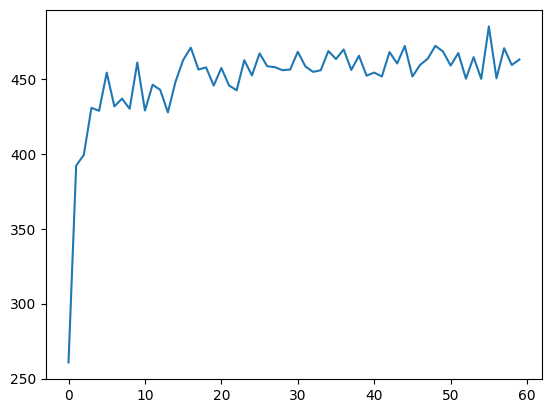

In [17]:
import matplotlib.pyplot as plt 
plt.plot(rewards_log)

In [18]:
len(global_buffer)

422967